# Exploring the Small Database (6,922 edits)

This notebook focuses on the **exploratory analysis and visualisation** of the cleaned and preprocessed dataset produced in the `preprocessing.ipynb` notebook.  
Its purpose is to develop an initial, data-driven understanding of **who edits, what is edited, and how editing activity is structured over time and across user types**.

Exploration is a critical intermediate step: it informs both methodological decisions and the interpretation of downstream analytical results.

---

## Scope of the Exploration

Using the preprocessed dataframe, this notebook explores several complementary dimensions of the data:

### 1. Users
- Distribution of edits by user and by user type (Registered, Anonymous (IP), Bot)
- Identification of highly active users
- Relative contribution of different user types to the dataset

### 2. Articles
- Most frequently edited articles
- Distribution of edits across articles
- Concentration of editorial activity on a small subset of pages

This helps identify **core articles** and potential focal points of controversy or strategic editing.

### 3. Temporal Distribution of Edits
- Number of edits over time (yearly evolution)
- Comparison of activity patterns across user types
- Detection of peaks or shifts in editing behaviour

Temporal analysis provides context for linking editorial activity to **external events or long-term trends**.

### 4. Edit Comments
- Presence and absence of edit comments
- Proportion of missing comments by user type
- Proportion of missing comments by both user type and edit type (weaponised vs not weaponised)

Edit comments are analysed as indicators of **editorial transparency, coordination, and accountability**.

### 5. Spatio-Temporal Heatmaps of Editing Activity

To capture fine-grained temporal patterns, the notebook includes several heatmaps:

- **Edits by year and weekday**
- **Edits by weekday and user type**
- Comparative heatmaps highlighting differences between weaponised and non-weaponised contexts

These visualisations reveal **rhythms of activity**, such as:
- weekday vs weekend behaviour,
- regularity vs burstiness,
- and differences in temporal strategies across user categories.

## Methodological Note

> **Note**  
> An initial, informal exploration phase was conducted prior to this notebook in order to identify appropriate cleaning and preprocessing strategies.  
> This early exploratory work is intentionally not documented here, in order to keep the analysis pipeline **lightweight, focused, and reproducible**.

## Research Objective

The goal of this exploratory notebook is not to test hypotheses, but to **surface patterns, anomalies, and structural regularities** in the data.  
These observations guide:
- subsequent analytical choices,
- feature selection,
- and the interpretation of behavioural signals related to **weaponisation and editorial dynamics**.

Ultimately, this exploratory step supports the extraction of robust, interpretable features for the development of a downstream **Large Language Model (LLM)** aimed at analysing or detecting coordinated or manipulative editing behaviour on Wikipedia.


In [21]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import numpy as np
import requests
import time
import calendar
from tqdm import tqdm

In [22]:
df = pd.read_csv('../../datas/final/small_db_preprocess.csv')

## Users we are dealing with

In [23]:
print(df["user"].nunique(), "unique users found")
print()
print(df["user"].value_counts().head(10))  # Top users by edit count 
users_list = df['user'].unique().tolist() # List of all the users that has made at least one edit in the df.
top_users = (
    df
    .groupby(["user", "weaponised"])
    .size()
    .sort_values(ascending=False)
    .head(10)
    .index
)
top_users_list = list(top_users) # List of the top 10 users that have made the most edits in the df.

2336 unique users found

user
LSGH                   372
TheDraperyFalls        254
Aleksandr Grigoryev    162
Toddy1                 147
UP9                    138
Yulia Romero           127
Irpen                  116
Seryo93                113
Dbachmann              111
Mzajac                  94
Name: count, dtype: int64


## Articles we are dealing with

In [24]:
def show_articles(dataframe):
    df = dataframe.copy()
    # Start from your grouped df
    df_sub = df.groupby(['article', 'weaponised']).size().reset_index(name='count')
    
    # Pivot the weaponised categories into columns
    pivot_df = df_sub.pivot(index='article', columns='weaponised', values='count')
    
    # Rename the resulting columns
    pivot_df = pivot_df.rename(columns={
        'Weaponised': 'weaponised_edits',
        'Not Weaponised': 'non_weaponised_edits'
    })
    
    # Replace missing values with 0 (some articles may not have both categories)
    pivot_df = pivot_df.fillna(0).astype(int)
    
    # Add total edits
    pivot_df['total_edits'] = (
        pivot_df['weaponised_edits'] + pivot_df['non_weaponised_edits']
    )
    
    pivot_df = pivot_df.sort_values('total_edits', ascending=False)
    return pivot_df

df_articles = show_articles(df)
df_articles

weaponised,non_weaponised_edits,weaponised_edits,total_edits
article,,,
COVID-19 pandemic in Ukraine,1247,75,1322
History of Ukraine,917,258,1175
Crimea,754,385,1139
Russian annexation of Crimea,335,167,502
2004 Ukrainian presidential election,367,58,425
Football in Ukraine,242,26,268
Bessarabia,204,51,255
2014 pro-Russian unrest in Ukraine,194,55,249
Communist Party of the Soviet Union,199,18,217


## Overall metadata of the dataframe 

In [25]:
dataframe_metadata = {
    # Overall dataset size
    "total_edits": len(df),
    "total_unique_users": df["user"].nunique(),
    "number_unique_articles": df["article"].nunique(),

    # User type counts (unique users)
    "num_bot_users": df.loc[df["user_type"] == "Bot", "user"].nunique(),
    "num_anonymous_users": df.loc[df["user_type"] == "Anonymous (IP)", "user"].nunique(),
    "num_registered_users": df.loc[df["user_type"] == "Registered", "user"].nunique(),

    # Edit counts by user type (just count rows)
    "num_bot_edits": int((df["user_type"] == "Bot").sum()),
    "num_anonymous_edits": int((df["user_type"] == "Anonymous (IP)").sum()),
    "num_registered_edits": int((df["user_type"] == "Registered").sum()),

    # Weaponisation counts
    "weaponised_edits": int((df["weaponised"] == "Weaponised").sum()),
    "non_weaponised_edits": int((df["weaponised"] == "Not Weaponised").sum())
}

dataframe_metadata

{'total_edits': 6922,
 'total_unique_users': 2336,
 'number_unique_articles': 40,
 'num_bot_users': 91,
 'num_anonymous_users': 966,
 'num_registered_users': 1279,
 'num_bot_edits': 287,
 'num_anonymous_edits': 1361,
 'num_registered_edits': 5274,
 'weaponised_edits': 1333,
 'non_weaponised_edits': 5589}

## Plots to show some distribution

The following plots provide a clearer view of how edits are distributed over time and across different user types. The user categories considered in this analysis are **Registered users, Bots, and IP users**. Registered users are contributors who have a Wikipedia account and can be identified by both a ```user_id``` and a ```username```. In contrast, IP users do not have an account and can only be identified through their ```IP address```.

The plots are displayed as the following :
* Weaponised vs Non-Weaponised Edits per Year
* Weaponised vs Non-Weaponised Edits by User Type
* Weaponised vs Non-Weaponised Edits per Year for Top 10 Users
* Proportion of Missing Comments by User Type
* Heatmap of Weaponised Edits per Day per Group over every year
* Heatmap of Weaponised Edits per Weekday per Group over every year

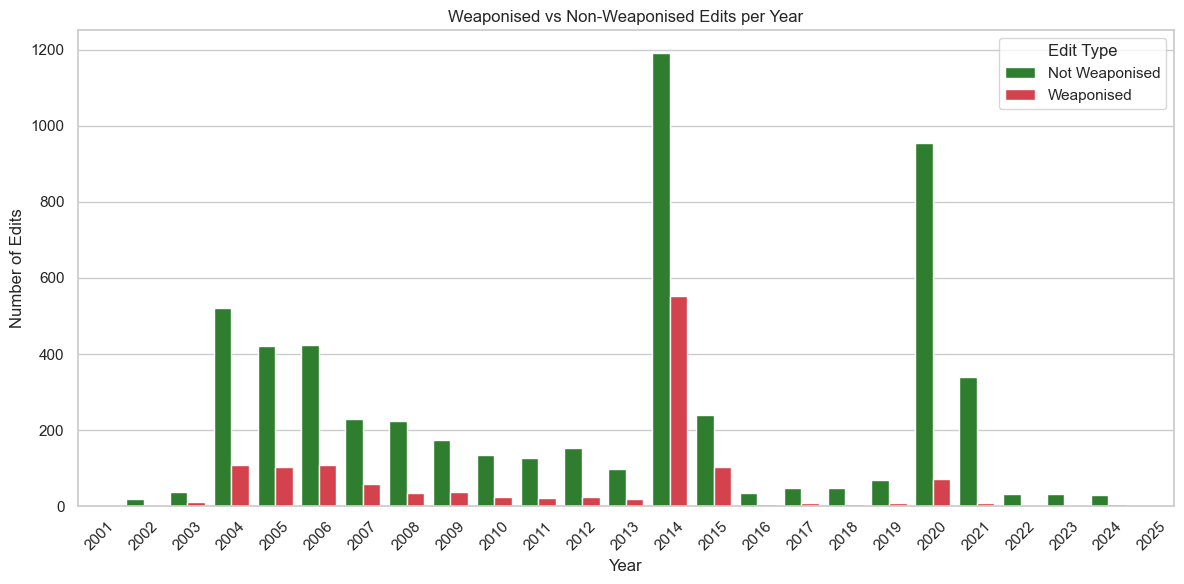

weaponised,Not Weaponised,Weaponised
year,,
2001,2.0,NaN
2002,20.0,2.0
2003,38.0,11.0
2004,522.0,109.0
2005,421.0,102.0
2006,425.0,109.0
2007,230.0,58.0
2008,224.0,36.0
2009,175.0,37.0


In [26]:
def plot_weap_vs_not_weap_per_year(dataframe, wanna_save=False):

    # Group counts
    df_counts = (
        df.groupby(["year", "weaponised"])
          .size()
          .reset_index(name="count")
    )

    custom_palette = {
        "Weaponised": "#ed2939",      # red
        "Not Weaponised": "forestgreen",  # royal blue
    }

    # Plot
    plt.figure(figsize=(12, 6))
    sns.set(style="whitegrid")
    sns.barplot(
        data=df_counts,
        x="year",
        y="count",
        hue="weaponised",
        palette=custom_palette
    )

    plt.title("Weaponised vs Non-Weaponised Edits per Year")
    plt.xlabel("Year")
    plt.ylabel("Number of Edits")
    plt.legend(title="Edit Type")
    plt.xticks(rotation=45)
    plt.tight_layout()

    if wanna_save:
        plt.savefig(
            "../../plots/All Users Analysis/Weaponised vs Non-Weaponised Edits per Year.png",
            dpi=300,
            bbox_inches='tight'
        )
    plt.show()

    return df_counts.pivot(index="year", columns="weaponised", values="count")

df_counts = plot_weap_vs_not_weap_per_year(df, wanna_save=True)
df_counts

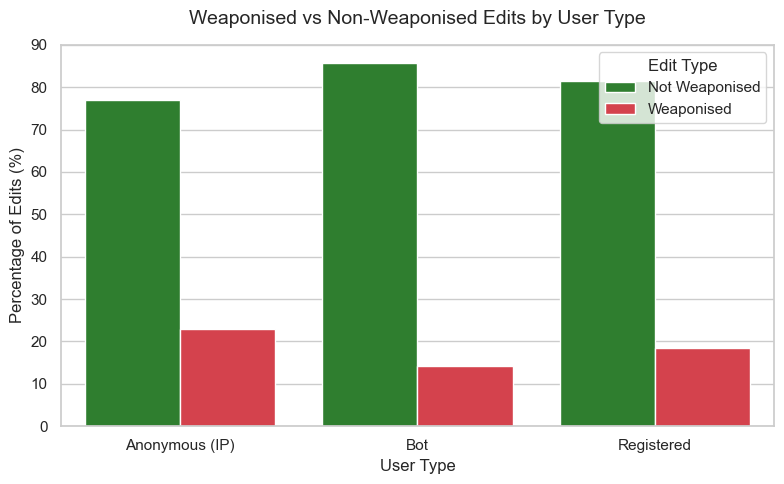

weaponised,Not Weaponised,Weaponised
user_type,,
Anonymous (IP),1048,313
Bot,246,41
Registered,4295,979


In [27]:
def plot_weap_vs_not_weap_per_user_type(dataframe, wanna_save=False):

    df = dataframe.copy()

    comparison = (
        df.groupby(["user_type", "weaponised"])
        .size()
        .reset_index(name="count")
    )
    
    # Compute total edits per user type and percentage of weaponised edits
    totals = comparison.groupby("user_type")["count"].sum().reset_index(name="total")
    comparison = comparison.merge(totals, on="user_type")
    comparison["percentage"] = (comparison["count"] / comparison["total"]) * 100
    
    custom_palette = {
        "Weaponised": "#ed2939",      # red
        "Not Weaponised": "forestgreen",   # royal blue
    }
    
    sns.set(style="whitegrid")
    
    plt.figure(figsize=(8, 5))
    sns.barplot(
        data=comparison,
        x="user_type",
        y="percentage",
        hue="weaponised",
        palette=custom_palette
    )
    
    plt.title("Weaponised vs Non-Weaponised Edits by User Type", fontsize=14, pad=15)
    plt.xlabel("User Type", fontsize=12)
    plt.ylabel("Percentage of Edits (%)", fontsize=12)
    plt.legend(title="Edit Type")
    plt.tight_layout()
    fig_title = 'Weaponised vs Non-Weaponised Edits by User Type'
    if wanna_save:
        plt.savefig(f"../../plots/All Users Analysis/{fig_title}.png", dpi=300, bbox_inches='tight')
    plt.show()

    return comparison.pivot(columns='weaponised', index='user_type', values='count')

comparison = plot_weap_vs_not_weap_per_user_type(df, True)
comparison

<Axes: title={'center': 'Proportion of Missing Comments by User Type'}, xlabel='User Type', ylabel='Missing Comments (%)'>

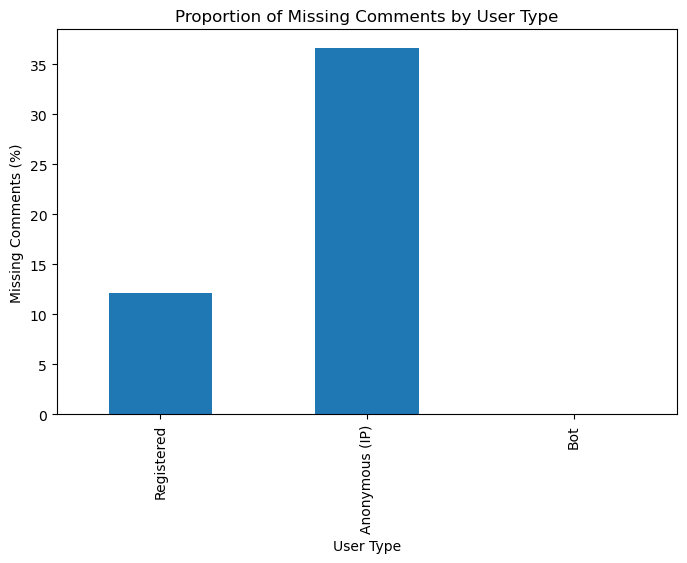

In [4]:
def plot_missing_comment_per_user_type(dataframe, wanna_save=False):

    df = dataframe.copy()
    
    missing = (
        df[df["comment"].isna()]
        .groupby("user_type")
        .size()
        .reset_index(name="missing_count")
    )
    
    total = (
        df.groupby("user_type")
        .size()
        .reset_index(name="total_count")
    )
    comparison = missing.merge(total, on="user_type", how="right").fillna(0)
    comparison["missing_percentage"] = (comparison["missing_count"] / comparison["total_count"]) * 100
    
    comparison = comparison[comparison["user_type"].isin(["Registered", "Anonymous (IP)", "Bot"])]
    
    custom_palette = {
        "Registered": "#a865b5",      
        "Anonymous (IP)": "#74c365", 
        "Bot": "#dfff00"
    }
    
    sns.set(style="whitegrid")
    plt.figure(figsize=(8, 5))
    
    sns.barplot(
        data=comparison,
        x="user_type",
        y="missing_percentage",
        hue='user_type',
        palette=custom_palette
    )
    
    plt.title("Proportion of Missing Comments by User Type", fontsize=14, pad=15)
    plt.xlabel("User Type", fontsize=12)
    plt.ylabel("Missing Comments (%)", fontsize=12)
    plt.tight_layout()
    
    legend_elements = [
        Patch(facecolor="#a865b5", label="Registered User"),
        Patch(facecolor="#74c365", label="Anonymous (IP) User"),
        Patch(facecolor="#dfff00", label="Bot")
    ]
    plt.legend(
        handles=legend_elements,
        title="User Type",
        loc="upper right",
        frameon=True
    )
    fig_title = "Proportion of Missing Comments by User Type"
    if wanna_save:
        plt.savefig(f"../../plots/Full Database/{fig_title}.png", dpi=300, bbox_inches="tight")
        
    plt.show()

(
    df.assign(missing=df["comment"].isna())
      .groupby("user_type")["missing"]
      .mean()
      .mul(100)
      .loc[["Registered", "Anonymous (IP)", "Bot"]]
      .plot(
          kind="bar",
          figsize=(8, 5),
          title="Proportion of Missing Comments by User Type",
          ylabel="Missing Comments (%)",
          xlabel="User Type",
          legend=False
      )
)


<Axes: title={'center': 'Proportion of Missing Comments by Edit Type and User Type'}, xlabel='Edit Type', ylabel='Missing Comments (%)'>

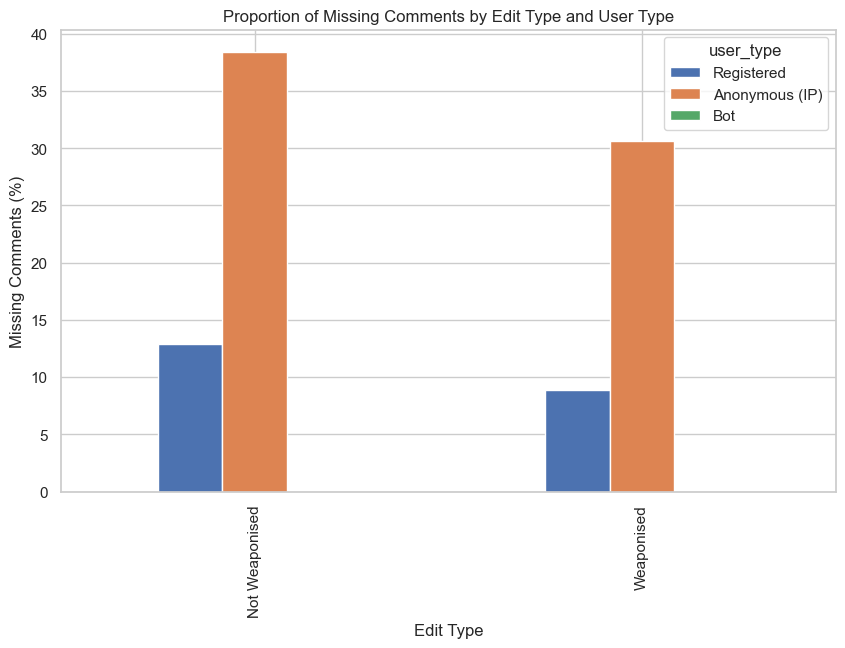

In [16]:
def plot_missing_comment_user_type_edit_type(dataframe, wanna_save=False):

    df = dataframe.copy()
    
    custom_palette = {
        "Registered": "#a865b5",
        "Anonymous (IP)": "#74c365",
        "Bot": "#dfff00"
    }
    
    missing = (
        df[df["comment"].isna()]
        .groupby(["user_type", "weaponised"])
        .size()
        .reset_index(name="missing_count")
    )
    
    # Total edits per edit type
    total = (
        df.groupby(["user_type", "weaponised"])
        .size()
        .reset_index(name="total_count")
    )
    
    # Merge & compute proportions
    comparison = total.merge(missing, on=["user_type", "weaponised"], how="left")
    comparison["missing_count"] = comparison["missing_count"].fillna(0)
    comparison["missing_percentage"] = (comparison["missing_count"] / comparison["total_count"]) * 100
    
    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 6))
    
    sns.barplot(
        data=comparison,
        x="weaponised",
        y="missing_percentage",
        hue="user_type",
        palette=custom_palette
    )
    
    plt.title("Proportion of Missing Comments by Edit Type and User Type", fontsize=14)
    plt.xlabel("Edit Type", fontsize=12)
    plt.ylabel("Missing Comments (%)", fontsize=12)
    plt.tight_layout()
    
    
    fig_title = "Proportion of Missing Comments by Edit Type and User Type"
    if wanna_save:
        plt.savefig(f"../../plots/All Users Analysis/{fig_title}.png", dpi=300, bbox_inches="tight")
    plt.show()

(
    df.assign(missing=df["comment"].isna())
      .groupby(["weaponised", "user_type"])["missing"]
      .mean()
      .mul(100)
      .unstack("user_type")
      .loc[:, ["Registered", "Anonymous (IP)", "Bot"]]
      .plot(
          kind="bar",
          figsize=(10, 6),
          title="Proportion of Missing Comments by Edit Type and User Type",
          ylabel="Missing Comments (%)",
          xlabel="Edit Type"
      )
)


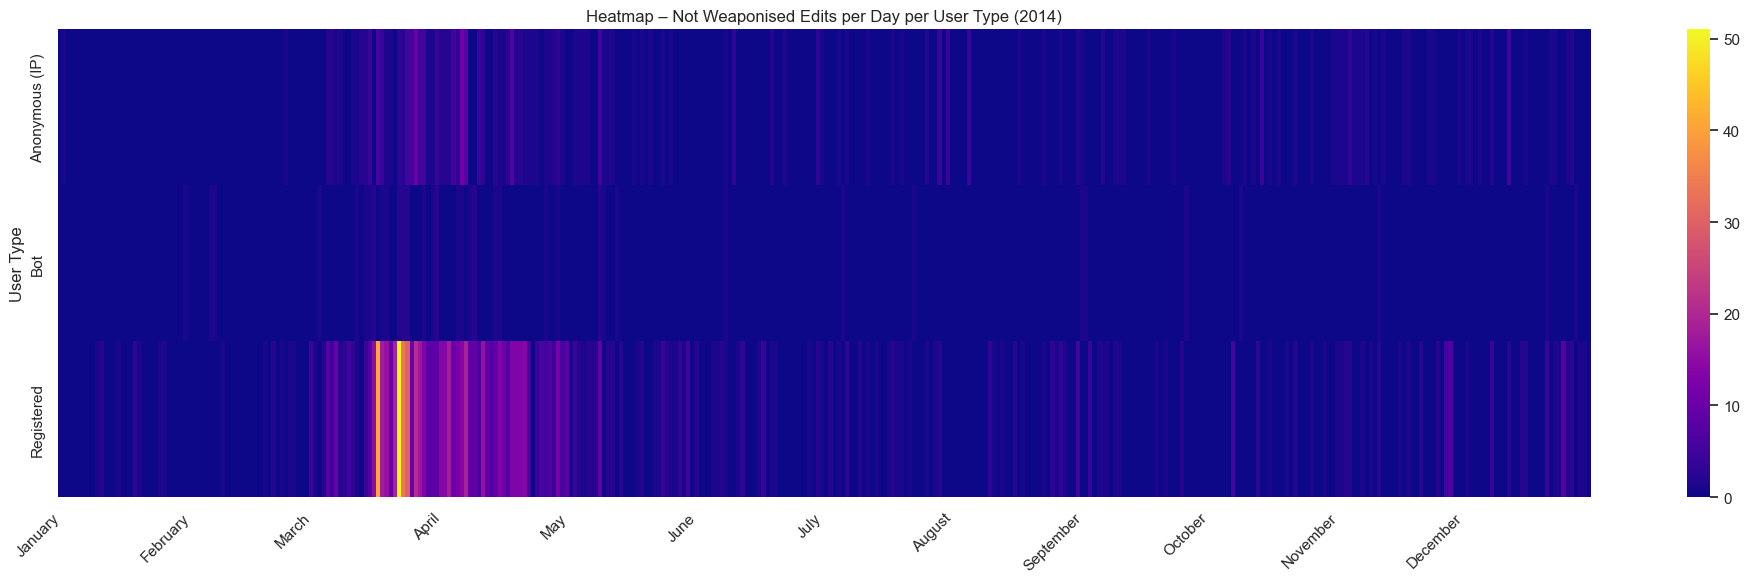

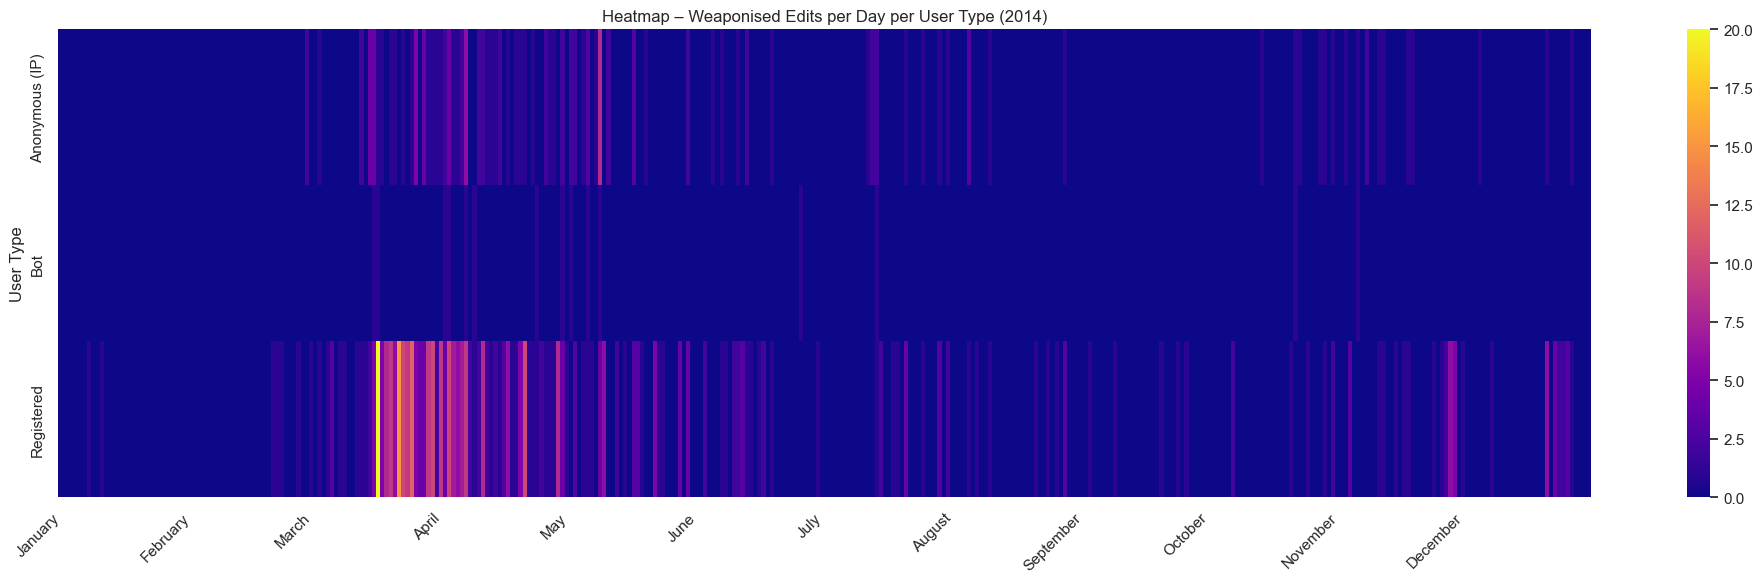

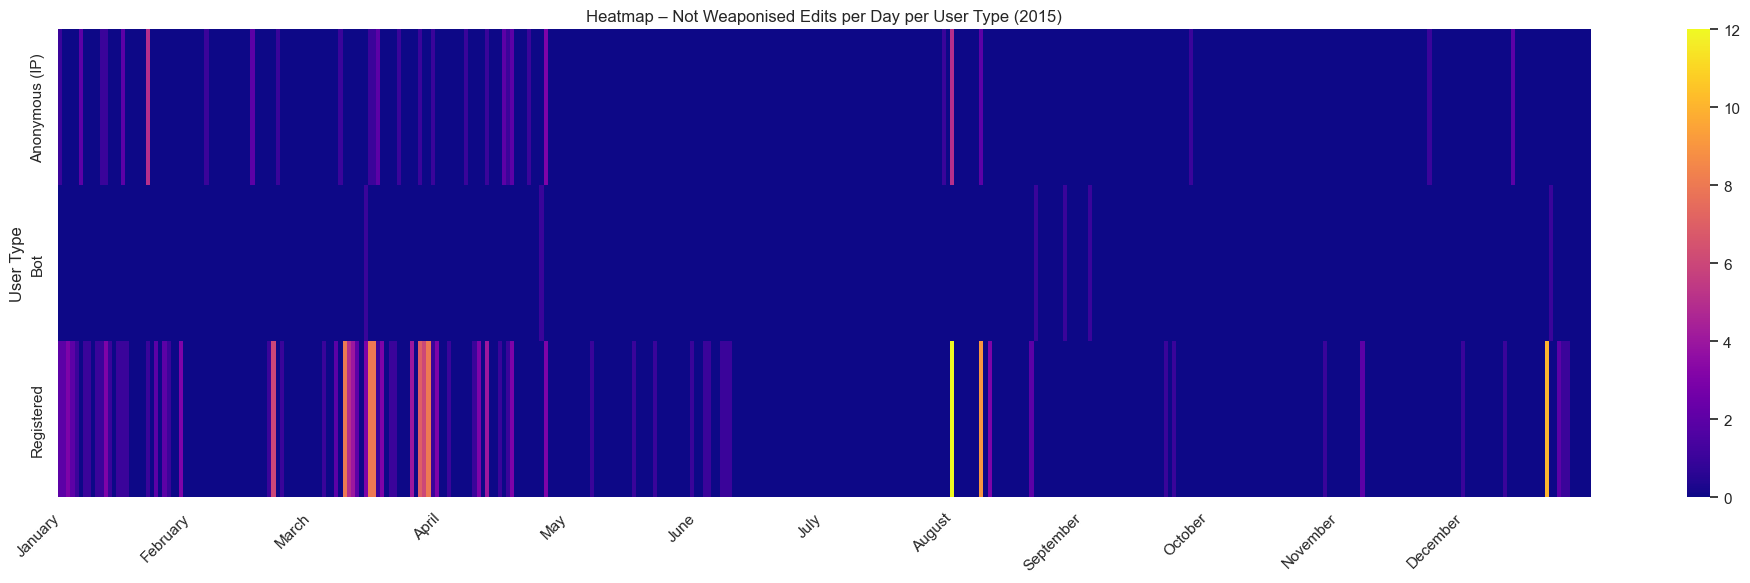

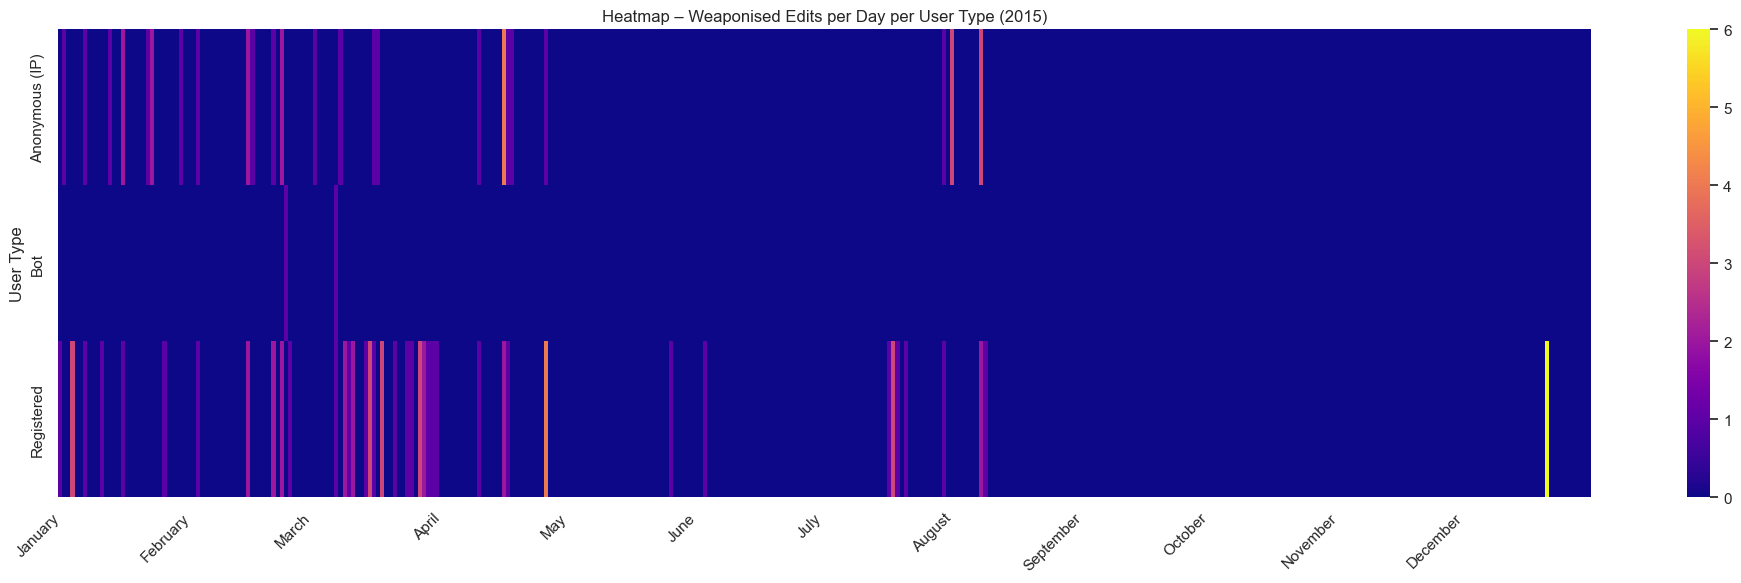

In [21]:
def plot_heatmaps_years(dataframe, years="all", wanna_save=False):

    dataframe = dataframe.copy()
    dt = pd.to_datetime(dataframe["date"], errors="coerce")
    dataframe["date"] = dt.dt.date
    dataframe["doy"] = dt.dt.dayofyear
    dataframe["year"] = dt.dt.year

    # The idea is to be able to choose to plot a specific year, all the years from 2001 to 2025 or a subset (2014, 2015, 2016)
    # all years in the range 2001–2025
    if years == "all":
        selected_years = list(range(2001, 2026))
    # single int
    elif isinstance(years, int):
        selected_years = [years]
    # list/tuple of ints
    else:
        selected_years = list(years)

    dataframe = dataframe[dataframe["year"].isin(selected_years)]

    month_starts = [pd.Timestamp(f"2024-{m:02d}-01").dayofyear for m in range(1, 13)]
    month_names = [calendar.month_name[m] for m in range(1, 13)]

    results = {}

    for year in selected_years:
        df_y = dataframe[dataframe["year"] == year]

        if df_y.empty:
            print(f"No data for year {year}. So we continue...")
            continue

        df_not = df_y[df_y["weaponised"] == "Not Weaponised"]
        df_weap = df_y[df_y["weaponised"] != "Not Weaponised"]

        daily_not = (
            df_not.groupby(["user_type", "date"])
            .size()
            .reset_index(name="count")
        )
        daily_weap = (
            df_weap.groupby(["user_type", "date"])
            .size()
            .reset_index(name="count")
        )

        daily_not["doy"] = pd.to_datetime(daily_not["date"]).dt.dayofyear
        daily_weap["doy"] = pd.to_datetime(daily_weap["date"]).dt.dayofyear

       
        hm_not = daily_not.pivot_table(
            index="user_type", columns="doy", values="count", aggfunc="sum"
        ).fillna(0)

        hm_weap = daily_weap.pivot_table(
            index="user_type", columns="doy", values="count", aggfunc="sum"
        ).fillna(0)

        hm_not = hm_not.reindex(columns=range(1, 367), fill_value=0)
        hm_weap = hm_weap.reindex(columns=range(1, 367), fill_value=0)

        if hm_not.empty:
            print(f"No NOT weaponised data for year {year}. Skipping heatmap…")
            
        else:
            plt.figure(figsize=(20, 6))
            sns.heatmap(hm_not, cmap="plasma", cbar=True)
    
            plt.xticks(month_starts, month_names, rotation=45, ha="right")
            plt.ylabel("User Type")
            plt.xlabel("")
            plt.title(f"Heatmap – Not Weaponised Edits per Day per User Type ({year})")
            plt.tight_layout()
    
            if wanna_save:
                plt.savefig(
                    f"../../plots/Full Database/Heatmap_Not_Weaponised_{year}.png",
                    dpi=300,
                    bbox_inches="tight"
                )
            plt.show()

        if hm_weap.empty:
            print(f"No weaponised data for year {year}. Skipping heatmap…")
        
        else:
            plt.figure(figsize=(20, 6))
            sns.heatmap(hm_weap, cmap="plasma", cbar=True)

            plt.xticks(month_starts, month_names, rotation=45, ha="right")
            plt.ylabel("User Type")
            plt.xlabel("")
            plt.title(f"Heatmap – Weaponised Edits per Day per User Type ({year})")
            plt.tight_layout()
    
            if wanna_save:
                plt.savefig(
                    f"../../plots/Full Database/Heatmap_Weaponised_{year}.png",
                    dpi=300,
                    bbox_inches="tight"
                )
            plt.show()

        results[year] = (hm_not, hm_weap)

plot_heatmaps_years(df, years=[2014, 2015], wanna_save=False)



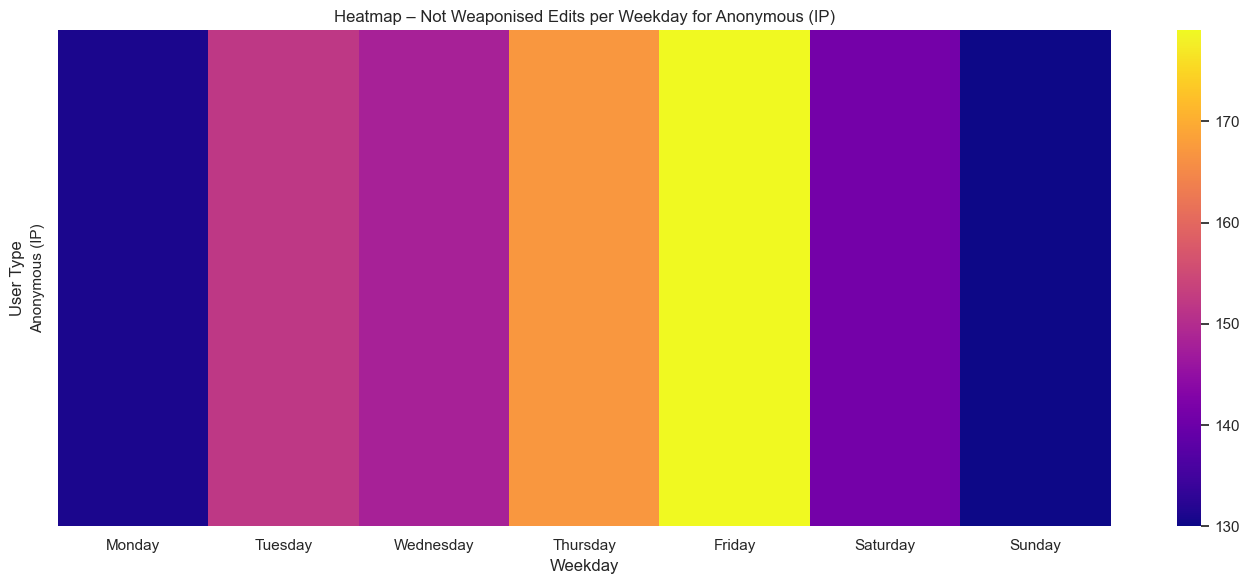

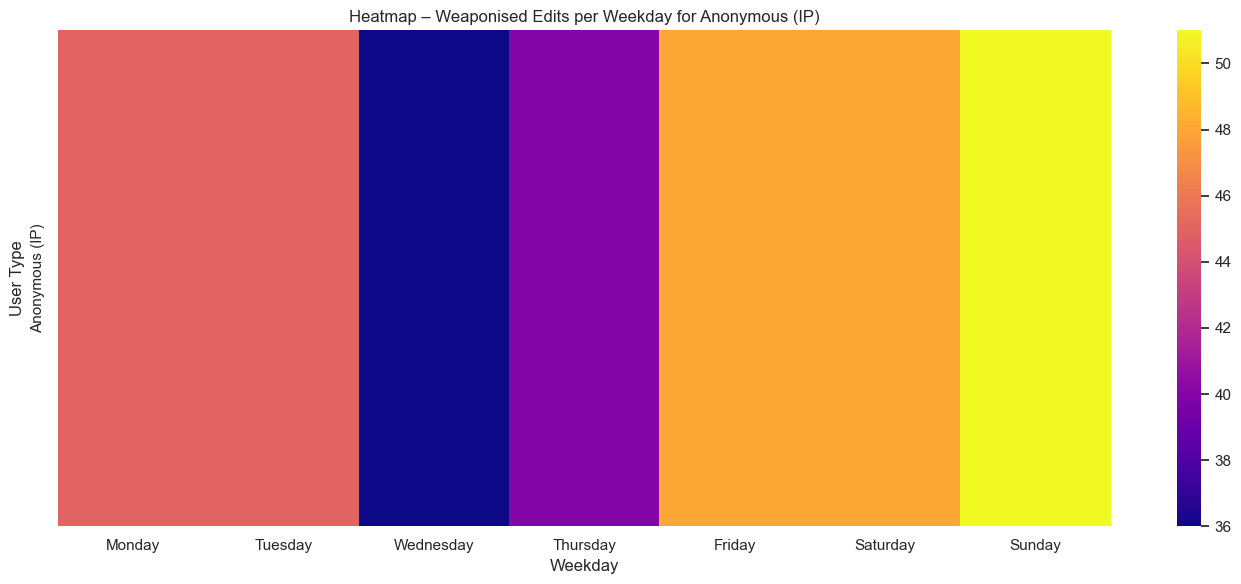

(weekday_name    Monday  Tuesday  Wednesday  Thursday  Friday  Saturday  Sunday
 user_type                                                                     
 Anonymous (IP)     131      152        148       167     179       141     130,
 weekday_name    Monday  Tuesday  Wednesday  Thursday  Friday  Saturday  Sunday
 user_type                                                                     
 Anonymous (IP)      45       45         36        40      48        48      51)

In [25]:
def plot_heatmap_weekdays(dataframe, wanna_save=False):
    
    df = dataframe.copy()
    df["date"] = pd.to_datetime(df["date"], errors="coerce")
    df["weekday"] = df["date"].dt.weekday          # 0=Mon, 6=Sun
    df["weekday_name"] = df["date"].dt.day_name()

   
    df_not = df[df["weaponised"] == "Not Weaponised"].copy()
    df_weap = df[df["weaponised"] != "Not Weaponised"].copy()

    
    daily_not = (
        df_not.groupby(["user_type", "weekday_name"])
        .size()
        .reset_index(name="count")
    )

    daily_weap = (
        df_weap.groupby(["user_type", "weekday_name"])
        .size()
        .reset_index(name="count")
    )

   
    hm_not = daily_not.pivot_table(
        index="user_type",
        columns="weekday_name",
        values="count",
        aggfunc="sum"
    ).fillna(0)

    hm_weap = daily_weap.pivot_table(
        index="user_type",
        columns="weekday_name",
        values="count",
        aggfunc="sum"
    ).fillna(0)

    
    ordered_days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
    hm_not = hm_not.reindex(columns=ordered_days, fill_value=0)
    hm_weap = hm_weap.reindex(columns=ordered_days, fill_value=0)

    
    plt.figure(figsize=(14, 6))
    sns.heatmap(hm_not, cmap="plasma", cbar=True)
    plt.xlabel("Weekday")
    plt.ylabel("User Type")
    plt.title("Heatmap – Not Weaponised Edits per Weekday per User Type")
    plt.tight_layout()

    if wanna_save:
        plt.savefig(
            "../../plots/Full Database/Heatmap_Weekday_Not_Weaponised.png",
            dpi=300, bbox_inches="tight"
        )
    plt.show()

    plt.figure(figsize=(14, 6))
    sns.heatmap(hm_weap, cmap="plasma", cbar=True)
    plt.xlabel("Weekday")
    plt.ylabel("User Type")
    plt.title("Heatmap – Weaponised Edits per Weekday per User Type")
    plt.tight_layout()

    if wanna_save:
        plt.savefig(
            "../../plots/Full Database/Heatmap_Weekday_Weaponised.png",
            dpi=300, bbox_inches="tight"
        )
    plt.show()

    return hm_not, hm_weap

def plot_heatmap_weekdays_user_type(dataframe, user_type = 'Anonymous (IP)', wanna_save=False):
    
    df = dataframe.copy()
    df["date"] = pd.to_datetime(df["date"], errors="coerce")
    df["weekday"] = df["date"].dt.weekday          # 0=Mon, 6=Sun
    df["weekday_name"] = df["date"].dt.day_name()
    df = df[df['user_type'] == user_type]
   
    df_not = df[df["weaponised"] == "Not Weaponised"].copy()
    df_weap = df[df["weaponised"] != "Not Weaponised"].copy()

    
    daily_not = (
        df_not.groupby(["user_type", "weekday_name"])
        .size()
        .reset_index(name="count")
    )

    daily_weap = (
        df_weap.groupby(["user_type", "weekday_name"])
        .size()
        .reset_index(name="count")
    )

   
    hm_not = daily_not.pivot_table(
        index="user_type",
        columns="weekday_name",
        values="count",
        aggfunc="sum"
    ).fillna(0)

    hm_weap = daily_weap.pivot_table(
        index="user_type",
        columns="weekday_name",
        values="count",
        aggfunc="sum"
    ).fillna(0)

    
    ordered_days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
    hm_not = hm_not.reindex(columns=ordered_days, fill_value=0)
    hm_weap = hm_weap.reindex(columns=ordered_days, fill_value=0)

    
    plt.figure(figsize=(14, 6))
    sns.heatmap(hm_not, cmap="plasma", cbar=True)
    plt.xlabel("Weekday")
    plt.ylabel("User Type")
    plt.title(f"Heatmap – Not Weaponised Edits per Weekday for {user_type}")
    plt.tight_layout()
    title_not = f"Heatmap – Not Weaponised Edits per Weekday for {user_type}"

    if wanna_save:
        plt.savefig(
            f"../../plots/Full Database/{title_not}.png",
            dpi=300, bbox_inches="tight"
        )
    plt.show()

    plt.figure(figsize=(14, 6))
    sns.heatmap(hm_weap, cmap="plasma", cbar=True)
    plt.xlabel("Weekday")
    plt.ylabel("User Type")
    plt.title(f"Heatmap – Weaponised Edits per Weekday for {user_type}")
    plt.tight_layout()
    title_weap = f"Heatmap – Weaponised Edits per Weekday for {user_type}"

    if wanna_save:
        plt.savefig(
            f"../../plots/Full Database/{title_weap}.png",
            dpi=300, bbox_inches="tight"
        )
    plt.show()

    return hm_not, hm_weap

plot_heatmap_weekdays_user_type(df, 'Anonymous (IP)', False)